In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import warnings
from colorama import Fore, Style
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
import lightgbm
from catboost import Pool, CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
import catboost

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [2]:
def amex_metric(y_true, y_pred, return_components=False) -> float:
    def top_four_percent_captured(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(df) -> float:
        """Corresponds to 2 * AUC - 1"""
        df2 = pd.DataFrame({'target': df.target, 'prediction': df.target})
        df2.sort_values('prediction', ascending=False, inplace=True)
        return weighted_gini(df) / weighted_gini(df2)

    df = pd.DataFrame({'target': y_true.ravel(), 'prediction': y_pred.ravel()})
    df.sort_values('prediction', ascending=False, inplace=True)
    g = normalized_weighted_gini(df)
    d = top_four_percent_captured(df)

    if return_components: return g, d, 0.5 * (g + d)
    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

In [13]:
CFG = {
    'num_folds': 5,


    'catboost': {
        'depth': 6,
        'iterations': 4000,
    },

    'make_submit': True,
    'seed': 777
}

In [4]:
features_avg = ['B_1', 'B_11', 'B_16', 'B_17', 'B_18', 'B_2', 'B_20',
                'B_28', 'B_3', 'B_4', 'B_5', 'B_7', 'B_9', 'D_112',
                'D_121', 'D_141', 'D_39', 'D_41', 'D_42', 'D_43',
                'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 
                'D_50', 'D_51', 'D_53', 'D_54', 'D_56', 'D_58', 
                'D_59', 'D_60', 'D_91', 'P_2', 'P_3', 'R_1', 'R_2', 
                'R_27', 'R_3', 'R_7', 'S_11', 'S_26', 'S_3', 'S_5']
features_last = ['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_15', 'B_16',
                 'B_17', 'B_18', 'B_19', 'B_2', 'B_20', 'B_22', 'B_23',
                 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_29', 'B_3',
                 'B_32', 'B_33', 'B_36', 'B_38', 'B_39', 'B_4', 'B_40',
                 'B_41', 'B_42', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9',
                 'D_102', 'D_103', 'D_105', 'D_106', 'D_107', 'D_109',
                 'D_112', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120',
                 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 
                 'D_129', 'D_132', 'D_133', 'D_135', 'D_136', 'D_137', 
                 'D_140', 'D_141', 'D_143', 'D_145', 'D_39', 'D_41',
                 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48',
                 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55',
                 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63',
                 'D_64', 'D_66', 'D_70', 'D_72', 'D_73', 'D_74', 'D_75',
                 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_82', 'D_83',
                 'D_84', 'D_86', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96',
                 'P_2', 'P_3', 'R_1', 'R_10', 'R_11', 'R_12', 'R_13',
                 'R_14', 'R_15', 'R_17', 'R_18', 'R_19', 'R_2', 'R_20', 
                 'R_21', 'R_22', 'R_24', 'R_25', 'R_26', 'R_27', 'R_3',
                 'R_4', 'R_5', 'R_7', 'R_8', 'R_9', 'S_11', 'S_12',
                 'S_13', 'S_15', 'S_17', 'S_20', 'S_22', 'S_23', 
                 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6',
                 'S_7', 'S_8', 'S_9']
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [5]:
def make_categorical_features(df):
    cat_df = pd.DataFrame([], index=df['customer_ID'].unique())
    for feature in cat_features:
        cl_sv = pd.pivot_table(df, index='customer_ID', columns=feature, values = 'P_2', aggfunc = 'count')
        cl_sv['summs'] = cl_sv.sum(axis=1)
        for i in cl_sv.columns[:-1]:
            cl_sv[i] = cl_sv[i] / cl_sv['summs']
        cl_sv.columns = [feature + '_'+ str(i) + '_count' for i in cl_sv.columns]
        cat_df = cat_df.merge(cl_sv, how='left', left_index=True, right_index=True)
    cat_df = cat_df.sort_index().fillna(0)
    del cl_sv
    return cat_df


def get_data(path, train=False):
    data = pd.read_feather(path)
    cat_df = make_categorical_features(data)
    if 'target' in data.columns:
        main_data = data.drop('target', axis=1).groupby('customer_ID').agg(['mean', 'median', 'std', 'min', 'max']).sort_index()
    else:
        main_data = data.groupby('customer_ID').agg(['mean', 'median', 'std', 'min', 'max']).sort_index()
    main_data.columns = [f'{x[0]}_{x[1]}' for x in main_data.columns]
    cid = pd.Categorical(data.pop('customer_ID'), ordered=True)
    last = (cid != np.roll(cid, -1))
    if train: target = data.loc[last, 'target']
    df_avg = data[features_avg].groupby(cid).mean().rename(columns={f: f"{f}_avg" for f in features_avg})
    data = data.loc[last, features_last].rename(columns={f: f"{f}_last" for f in features_last}).set_index(np.asarray(cid[last]))
    data = pd.concat([data, df_avg, cat_df, main_data], axis=1)
    cat_features = data.select_dtypes(['category']).columns.tolist()
    data[cat_features] = data[cat_features].astype('str')

    if train: return data, target
    else: return data, cat_features

train_data, target = get_data('data/train_data.ftr', train=True)
test_data, cat_features = get_data('data/test_data.ftr')

le_encoder = LabelEncoder()
for feature in cat_features:
    train_data[feature] = le_encoder.fit_transform(train_data[feature])
    test_data[feature] = le_encoder.transform(test_data[feature])

gc.collect()

/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_14870/1435474558.py:19: FutureWarning: ['S_2', 'D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  main_data = data.drop('target', axis=1).groupby('customer_ID').agg(['mean', 'median', 'std', 'min', 'max']).sort_index()
/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_14870/1435474558.py:21: FutureWarning: ['S_2', 'D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  main_data = data.groupby('customer_ID').agg(['mean', 'median', 'std', 'min', 'max']).sort_index()


0

In [6]:
model = CatBoostClassifier(
    depth=CFG['catboost']['depth'],
    iterations=CFG['catboost']['iterations'],
    learning_rate=0.04,
    custom_metric=['AUC'],
    random_seed=CFG['seed'],
    thread_count=6,
    early_stopping_rounds=300
)
features = [f for f in train_data.columns if f not in ('customer_ID', 'target')]
model.fit(Pool(train_data[features], target, cat_features=cat_features), verbose=100)

0:	learn: 0.6428984	total: 539ms	remaining: 26m 56s
100:	learn: 0.2345967	total: 38.9s	remaining: 18m 36s
200:	learn: 0.2260893	total: 1m 15s	remaining: 17m 35s
300:	learn: 0.2222129	total: 1m 54s	remaining: 17m 5s
400:	learn: 0.2191889	total: 2m 31s	remaining: 16m 21s
500:	learn: 0.2167435	total: 3m 8s	remaining: 15m 38s
600:	learn: 0.2146679	total: 3m 44s	remaining: 14m 56s
700:	learn: 0.2128432	total: 4m 20s	remaining: 14m 14s
800:	learn: 0.2111481	total: 4m 56s	remaining: 13m 32s
900:	learn: 0.2095148	total: 5m 31s	remaining: 12m 52s
1000:	learn: 0.2080042	total: 6m 6s	remaining: 12m 12s
1100:	learn: 0.2065061	total: 6m 42s	remaining: 11m 34s
1200:	learn: 0.2050566	total: 7m 17s	remaining: 10m 56s
1300:	learn: 0.2036403	total: 7m 53s	remaining: 10m 18s
1400:	learn: 0.2022723	total: 8m 28s	remaining: 9m 40s
1500:	learn: 0.2009603	total: 9m 3s	remaining: 9m 2s
1600:	learn: 0.1996685	total: 9m 38s	remaining: 8m 25s
1700:	learn: 0.1983701	total: 10m 13s	remaining: 7m 48s
1800:	learn: 0

In [7]:
feature_imp = model.get_feature_importance()
bad_cols = [features[i] for i in range(len(features)) if feature_imp[i] < 0.03]
train_data.drop(bad_cols, axis=1, inplace=True)
print(len(cat_features))
cat_features = [x for x in cat_features if x in train_data.columns.tolist()]
print(len(cat_features))

6
3


In [14]:
# not_found = []
# for feature in train_data.columns.tolist():
#     if feature not in test_data.columns.tolist():
#         not_found.append(feature)
# test_data = test_data.assign(**dict.fromkeys(not_found, 0))

score_list, y_pred_list = [], []
kf = StratifiedKFold(n_splits=CFG['num_folds'], random_state=CFG['seed'], shuffle=True)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_data, target)):
    start_time = datetime.datetime.now()
    X_tr, X_va = train_data.iloc[idx_tr], train_data.iloc[idx_va]
    y_tr, y_va = target.iloc[idx_tr], target.iloc[idx_va]
    
    model = CatBoostClassifier(
        depth=CFG['catboost']['depth'],
        iterations=CFG['catboost']['iterations'],
        learning_rate=0.06,
        custom_metric=['AUC'],
        random_seed=CFG['seed'],
        thread_count=6,
        early_stopping_rounds=300
    )
    model.fit(Pool(X_tr, y_tr, cat_features=cat_features),
              eval_set=Pool(X_va, y_va, cat_features=cat_features),
              verbose=100)

    y_va_pred = model.predict_proba(Pool(X_va, cat_features=cat_features))[:,1]
    score = amex_metric(y_va.values, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)

    y_pred_list.append(model.predict_proba(Pool(test_data[train_data.columns], cat_features=cat_features))[:,1])
    gc.collect()

print(f"{Fore.RED}{Style.BRIGHT}OOF Score:   {np.mean(score_list):.5f}{Style.RESET_ALL}")

0:	learn: 0.6202935	test: 0.6200697	best: 0.6200697 (0)	total: 261ms	remaining: 17m 22s
100:	learn: 0.2294798	test: 0.2287188	best: 0.2287188 (100)	total: 16.2s	remaining: 10m 25s
200:	learn: 0.2221526	test: 0.2229126	best: 0.2229126 (200)	total: 31.4s	remaining: 9m 52s
300:	learn: 0.2175005	test: 0.2203136	best: 0.2203136 (300)	total: 46.7s	remaining: 9m 33s
400:	learn: 0.2139539	test: 0.2189440	best: 0.2189440 (400)	total: 1m 1s	remaining: 9m 14s
500:	learn: 0.2108804	test: 0.2180958	best: 0.2180958 (500)	total: 1m 16s	remaining: 8m 55s
600:	learn: 0.2080278	test: 0.2175131	best: 0.2175131 (600)	total: 1m 31s	remaining: 8m 38s
700:	learn: 0.2054306	test: 0.2171905	best: 0.2171905 (700)	total: 1m 46s	remaining: 8m 19s
800:	learn: 0.2029104	test: 0.2168494	best: 0.2168371 (793)	total: 2m 1s	remaining: 8m 3s
900:	learn: 0.2005286	test: 0.2166437	best: 0.2166403 (899)	total: 2m 16s	remaining: 7m 47s
1000:	learn: 0.1982271	test: 0.2164555	best: 0.2164530 (994)	total: 2m 30s	remaining: 7m 

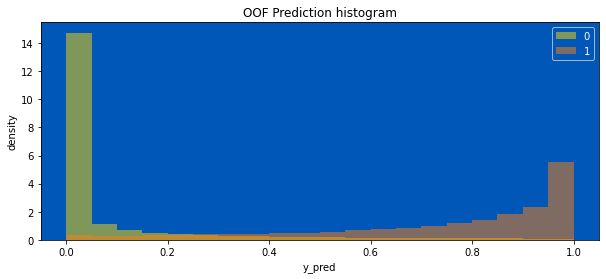

In [18]:
plt.figure(figsize=(10, 4))
plt.hist(y_va_pred[y_va == 0], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='0')
plt.hist(y_va_pred[y_va == 1], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='k')
plt.legend()
plt.show()

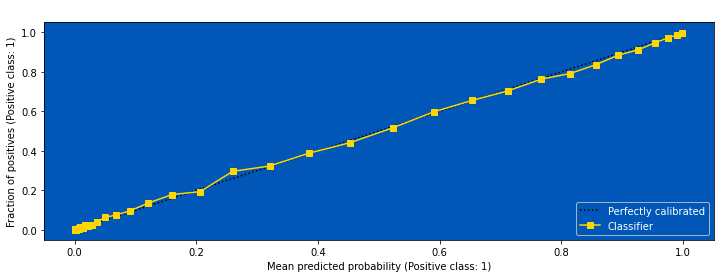

In [19]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, y_va_pred, n_bins=50, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

In [20]:
if CFG['make_submit']:
    sub = pd.DataFrame({'customer_ID': test_data.index,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub.to_csv('submission_v5.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.033475
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001479
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.033408
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.181198
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.805576
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.011435
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.781314
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.381806
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.283175
